<a href="https://colab.research.google.com/github/Ranadip213/Ranadip213/blob/main/crowd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [7]:
# Image IDs and target values.
META_FILE = '/content/labels.csv'

In [8]:
# EfficientDet model
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'

In [20]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'/content/frames/seq_{image_id}.jpg'


def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)


def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()


def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image


def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [21]:
set_display()

In [22]:
# Input data
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,/content/frames/seq_000001.jpg
1,2,41,/content/frames/seq_000002.jpg
2,3,41,/content/frames/seq_000003.jpg
3,4,44,/content/frames/seq_000004.jpg
4,5,41,/content/frames/seq_000005.jpg


In [23]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


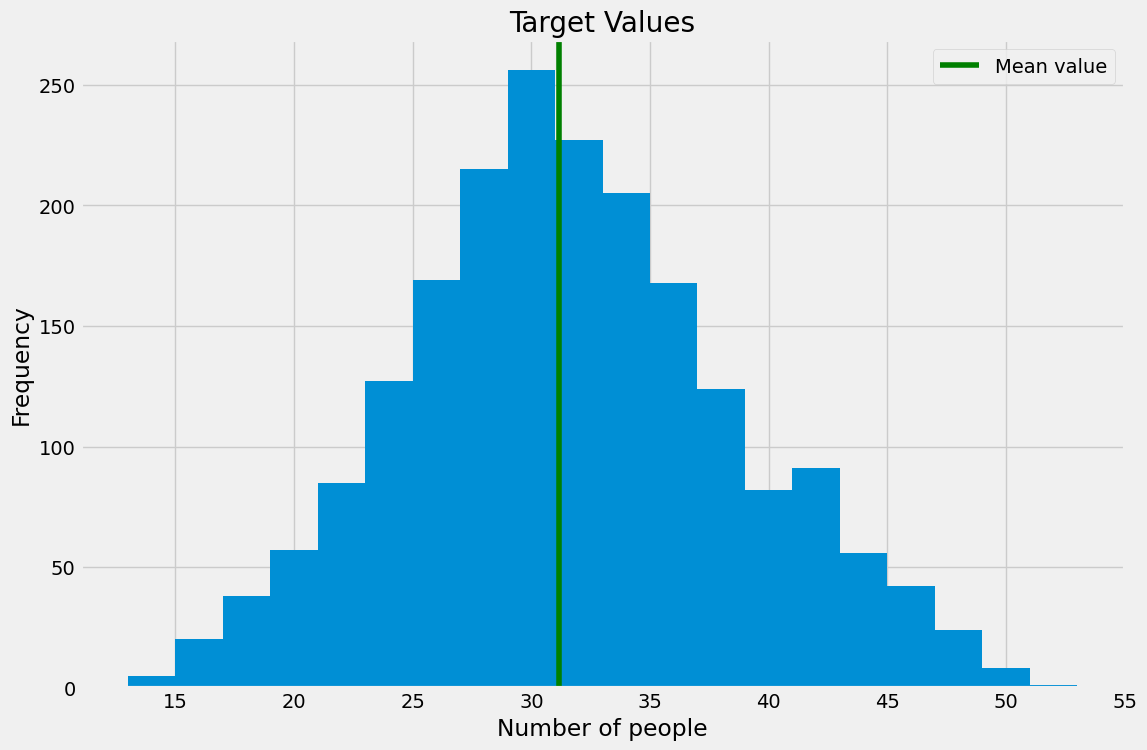

In [24]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [25]:
# Load the model.
detector = hub.load(MODEL_PATH)

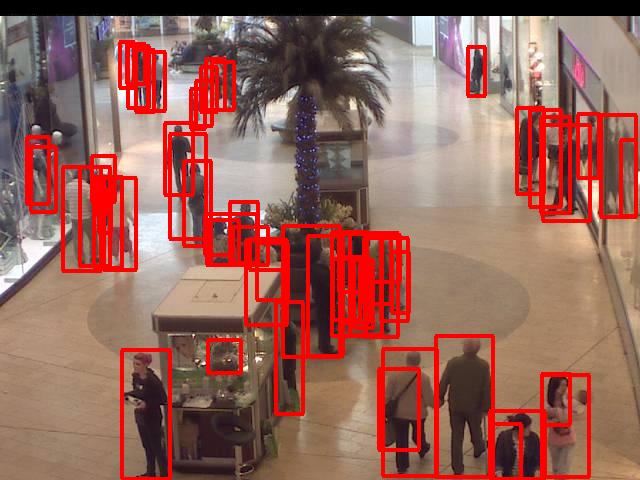

In [ ]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '/content/frames/seq_000001.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)


In [16]:
!unzip /content/frames.zip

Archive:  /content/frames.zip
   creating: frames/
  inflating: frames/seq_000399.jpg   
  inflating: frames/seq_000372.jpg   
  inflating: frames/seq_000184.jpg   
  inflating: frames/seq_000321.jpg   
  inflating: frames/seq_000294.jpg   
  inflating: frames/seq_000176.jpg   
  inflating: frames/seq_000133.jpg   
  inflating: frames/seq_000313.jpg   
  inflating: frames/seq_000015.jpg   
  inflating: frames/seq_000168.jpg   
  inflating: frames/seq_000125.jpg   
  inflating: frames/seq_000200.jpg   
  inflating: frames/seq_000235.jpg   
  inflating: frames/seq_000305.jpg   
  inflating: frames/seq_000117.jpg   
  inflating: frames/seq_000227.jpg   
  inflating: frames/seq_000040.jpg   
  inflating: frames/seq_000150.jpg   
  inflating: frames/seq_000032.jpg   
  inflating: frames/seq_000373.jpg   
  inflating: frames/seq_000142.jpg   
  inflating: frames/seq_000067.jpg   
  inflating: frames/seq_000059.jpg   
  inflating: frames/seq_000314.jpg   
  inflating: frames/seq_000016.jpg   

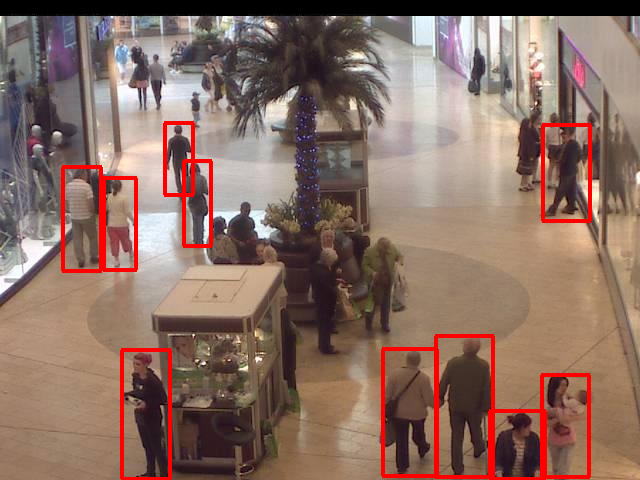

In [ ]:
# With high threshold the model underestimates the number of people
# selecting only the most obvious objects at the foreground.
draw_bboxes(example_path, results, threshold=0.5)

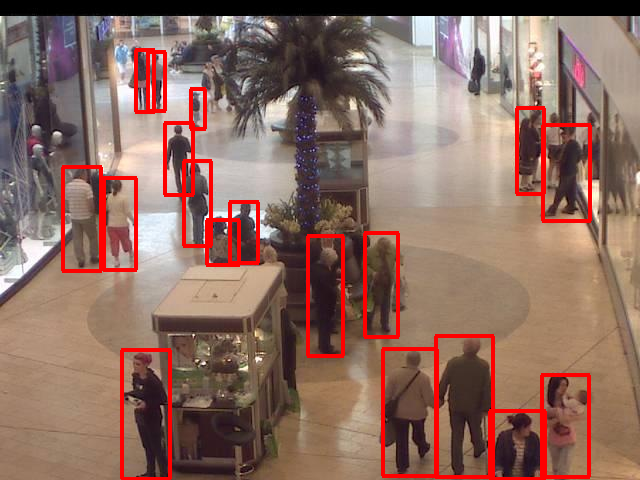

In [ ]:
# With relatively low threshold the model is most accurate counting people
# that are located at the foreground and the middle of the picture.
# Objects at the background are mostly ignored.
draw_bboxes(example_path, results, threshold=0.25)

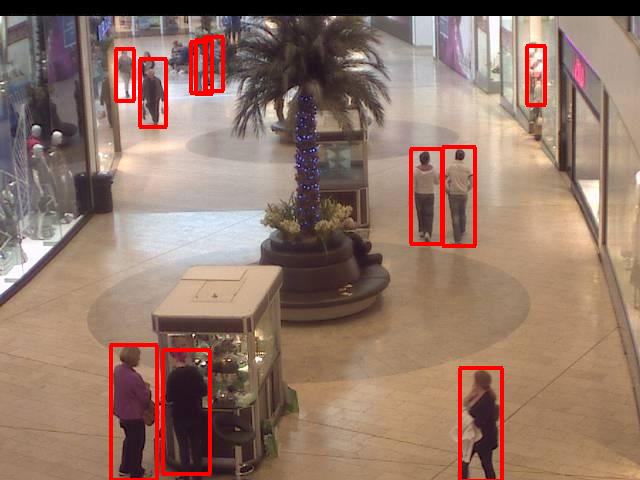

In [26]:
# Test the model on an image with small number of people.
example_path = data.loc[data['count'] == data['count'].min(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

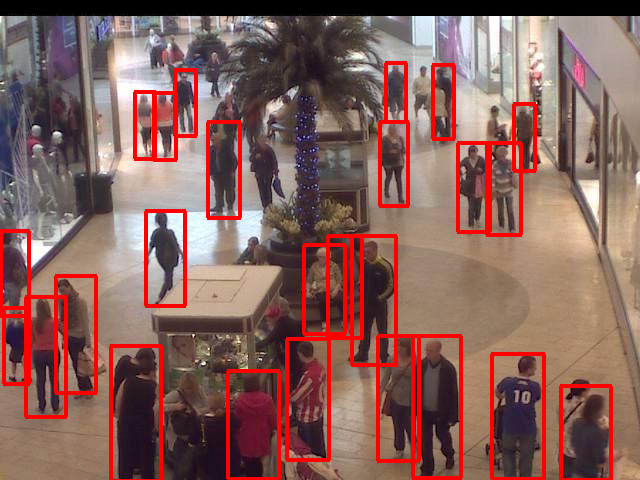

In [27]:
# Test the model on a very crowded image.
example_path = data.loc[data['count'] == data['count'].max(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)


In [28]:
sample = data.sample(frac=0.1)
start = time.perf_counter()
objects = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(count_persons, path, detector, 0.25) for path in sample['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        objects.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

200it [01:55,  1.73it/s]

Finished in 115.68 second(s).


In [ ]:
!unzip /content/images.npy.zip

In [29]:
# Compare predicted values with the ground truth.
sample['prediction'] = objects
sample.head(10)

,id,count,path,prediction
1290,1291,26,/content/frames/seq_001291.jpg,23
137,138,41,/content/frames/seq_000138.jpg,16
1513,1514,21,/content/frames/seq_001514.jpg,20
538,539,19,/content/frames/seq_000539.jpg,12
725,726,48,/content/frames/seq_000726.jpg,23
29,30,27,/content/frames/seq_000030.jpg,16
1008,1009,38,/content/frames/seq_001009.jpg,20
1833,1834,32,/content/frames/seq_001834.jpg,21
1177,1178,43,/content/frames/seq_001178.jpg,21
515,516,27,/content/frames/seq_000516.jpg,21


MAE = 12.915
MSE = 230.335


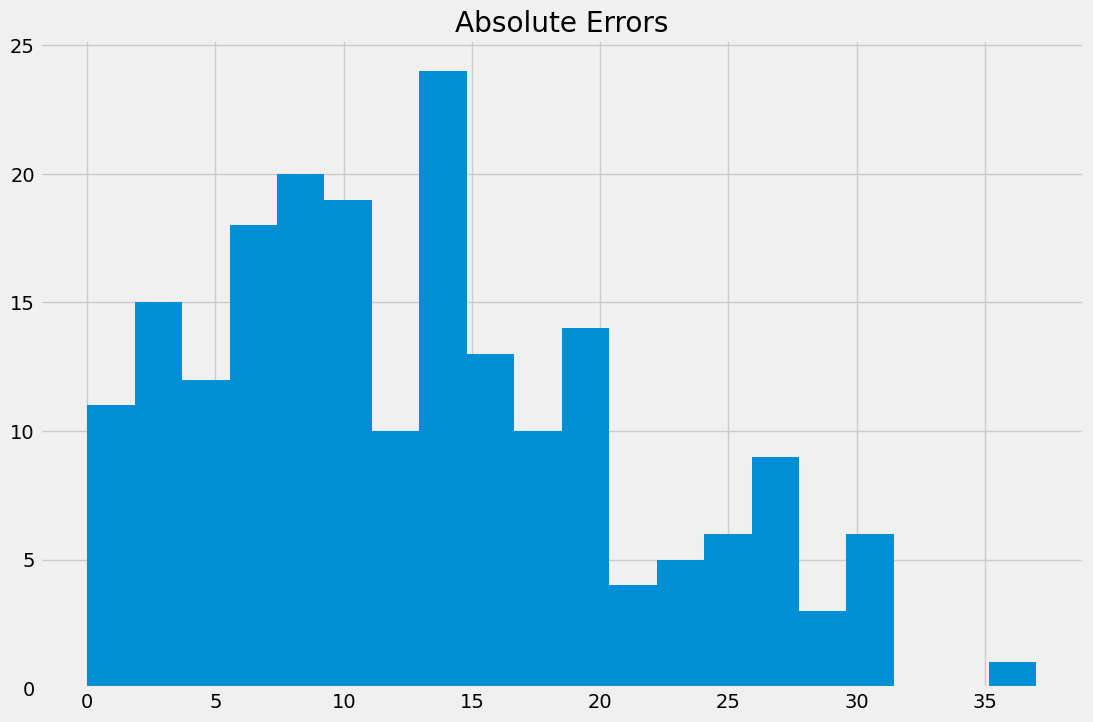

In [30]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

print(f'MAE = {sample["mae"].mean()}\nMSE = {sample["mse"].mean()}')
plt.hist(sample['mae'], bins=20)
plt.title('Absolute Errors')
plt.show()

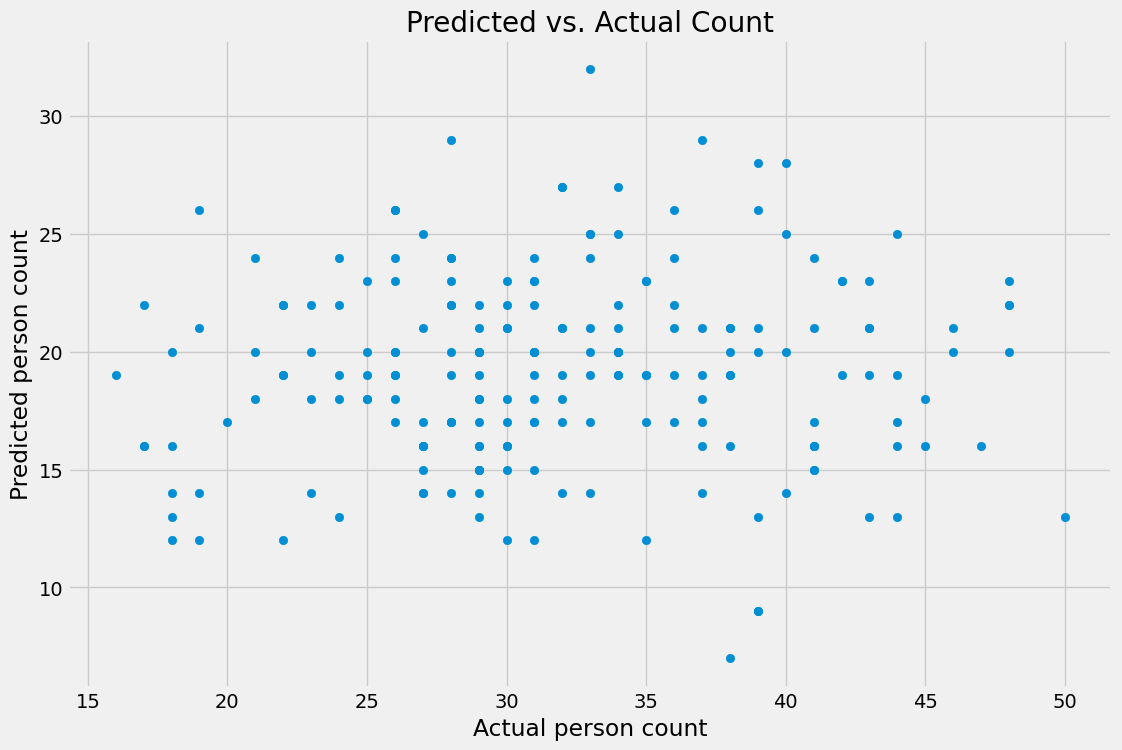

In [31]:
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel('Actual person count')
plt.ylabel('Predicted person count')
plt.title('Predicted vs. Actual Count')
plt.show()

In [32]:
import os
import random

In [33]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 500
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [34]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image


def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [35]:
set_seed()

In [36]:
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count']))
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count']))

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

In [ ]:
# Load the model.
model = create_model()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=EPOCHS, callbacks=[early_stop, lr_reduction],
                    use_multiprocessing=True, workers=os.cpu_count())

Epoch 1/500
107/107 [==============================] - 960s 9s/step - loss: 64.3309 - mean_absolute_error: 6.3163 - val_loss: 47.5784 - val_mean_absolute_error: 6.0521 - lr: 0.0010
Epoch 2/500
 80/107 [=====================>........] - ETA: 3:05 - loss: 49.0743 - mean_absolute_error: 5.7057